<div style="text-align: center; font-size: 30px; font-weight: bold;">
    Assignment/Lab 3: Winter 2025 Group 2
    <br>***
</div>

<h1>Team members</h1>
<b>
    
- Minh Le Nguyen
- Liam Knapp
- Gautam Singh
- Gleb Ignatov

</b>
<br>

---

<div style="text-align: center; font-size: 24px; font-weight: bold;">
    Hands-On with Real Data: Model Evaluation and Hyperparameter Tuning
</div>

## I. Objectives

<b>
    
- Preprocess a real dataset to handle missing values and categorical variables.  
- Explore feature scaling techniques
- Train and evaluate machine learning models. 
- Tune hyperparameters for a machine learning model.
- Use cross-validation techniques.
- Compare different machine learning models and choose the best one based on their performance metrics.
    
</b>

**Note: Intructions Details at the bottoms**

---

## II. Implementation

### Set up your Python development environment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, skew, kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


---

### Step 1: Load, Explore and Preprocess the Dataset      

In this step, your task is to explore and preprocess the dataset using your machine learning and visualization skills. This includes, but is not limited to:<br>
• Handle missing values. Since the data is small, do not remove any data—you must impute any missing values. <br>
• Scale the features if needed.<br>
• Convert categorical variables.<br>
• Use visualization to explore the dataset<br>

In [24]:
class step_1_load_explore():
    def __init__(self, processing_file_path):
        self.raw_df = pd.read_csv(processing_file_path)
        self.raw_df.index = self.raw_df["PassengerId"]

    def print_dataframe_metadata(self):
        """
        Prints metadata information about a Pandas DataFrame.
        
        Parameters:
        raw_df (pd.DataFrame): The DataFrame for which metadata is to be printed.
        """
        print("DataFrame Metadata\n")

        print("\nSummary Statistics:\n")
        print(self.raw_df.describe(include='all'))
        print("\n================================================================\n")
        
        print("\nShape:\n", self.raw_df.shape)
        print("\n================================================================\n")
        
        print("\nMissing Values:\n")
        print(self.raw_df.isnull().sum())
        print("\n================================================================\n")
        
        print("\nList of Columns:\n")
        print(self.raw_df.columns.to_list())
        print("\n================================================================\n")

        print("\nColumns and Data Types:\n")
        print(self.raw_df.dtypes)
        print("\n================================================================\n")
                
        print("\nUnique Values per Column:\n")
        print(self.raw_df.nunique())
        print("\n================================================================\n")

        print("\nUnique Values per Column:\n")
        for col in self.raw_df.columns:
            print(self.raw_df[col].unique())
            print("\n================================================================\n")
        
        print("\nFirst 5 Rows:\n")
        print(self.raw_df.head())
        print("\n================================================================\n")


    def checking_missing_value(self, input_col_obj, mode="single"):
        if mode == "single" and isinstance(input_col_obj, str):
            df_missing_values_dict = dict()
            df_missing_values_dict[input_col_obj] = self.raw_df[input_col_obj].isnull().sum()
            missing_values_df = pd.DataFrame(
                list(df_missing_values_dict.items()),
                columns=["Column Name", "Number of missing values"]
            )
            return missing_values_df
        elif mode == "multiple" and isinstance(input_col_obj, list):
            df_missing_values_dict = dict()
            for col in input_col_obj:
                df_missing_values_dict[col] = self.raw_df[col].isnull().sum()
            
            missing_values_df = pd.DataFrame(
                list(df_missing_values_dict.items()),
                columns=["Column Name", "Number of missing values"]
            )
            return missing_values_df
        else:
            return "Please check the function again"

    def distribution_shape_analytics(self, df_input, column_input):
        df_process_dis = df_input.dropna().copy()
        # Distribution Shape
        skewness_temp = skew(df_process_dis[column_input])
        kurtosis_temp = kurtosis(df_process_dis[column_input])
        print("Distribution Shape Analytics for AverageTemperature:")
        print(f"Distribution Shape - Skewness: {round(skewness_temp,2)}, Kurtosis: {round(kurtosis_temp,2)}")
        if skewness_temp > 0:
            print("The distribution is positively skewed, indicating a longer tail on the right.")
        elif skewness_temp < 0:
            print("The distribution is negatively skewed, indicating a longer tail on the left.")
        else:
            print("The distribution is symmetric.")
        
        if kurtosis_temp > 0:
            print("The distribution has heavier tails and a sharper peak than a normal distribution (leptokurtic).")
        elif kurtosis_temp < 0:
            print("The distribution has lighter tails and a flatter peak than a normal distribution (platykurtic).")
        else:
            print("The distribution has a kurtosis similar to a normal distribution (mesokurtic).")
        print("\n")
        return skewness_temp, kurtosis_temp
    
    def fill_missing_values(self, column_name, fill_value):
        self.raw_df[column_name] = self.raw_df[column_name].fillna(fill_value)
        return self.raw_df
        
    def plot_histogram(self, df_input, column_name, default_bin=10):
        df_processed = df_input.dropna().copy()
        column_data = df_processed[column_name].dropna()
        iqr = np.percentile(column_data, 75) - np.percentile(column_data, 25)
        bin_width_fd = 2 * iqr / (len(column_data) ** (1 / 3))
        if bin_width_fd > 0:
            n_bins_fd = int(np.ceil((column_data.max() - column_data.min()) / bin_width_fd))
        else:
            n_bins_fd = default_bin

        plt.figure(figsize=(6, 4))
        sns.histplot(column_data, bins=n_bins_fd, kde=True, color="blue", alpha=0.6)
        plt.title(f'Histogram of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def detect_outlier(self, column_input):
        df_outliers_detect = self.raw_df.dropna().copy()
        df_outliers_detect['Z_Score'] = zscore(df_outliers_detect[column_input])
        z_outliers = df_outliers_detect[abs(df_outliers_detect['Z_Score']) > 3]
        num_z_outliers = len(z_outliers)
        Q1 = df_outliers_detect[column_input].quantile(0.25)
        Q3 = df_outliers_detect[column_input].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = df_outliers_detect[(df_outliers_detect[column_input] < lower_bound) | 
                                        (df_outliers_detect[column_input] > upper_bound)]
        num_iqr_outliers = len(iqr_outliers)
        df_outliers_detect['IQR_Outlier'] = (df_outliers_detect[column_input] < lower_bound) | (df_outliers_detect[column_input] > upper_bound)
        print(f"Number of outliers detected by Z-score method: {num_z_outliers}")
        print(f"Number of outliers detected by IQR method: {num_iqr_outliers}")
        return num_z_outliers, num_iqr_outliers
    
    def scale_numerical_variables(self, df_input, column_name, method="Min-Max"):
        df_processed = df_input.dropna().copy()
        if method == "Min-Max":
            scaler = MinMaxScaler()
            df_processed[column_name] = scaler.fit_transform(df_processed[[column_name]])
            return df_processed
        elif method == "Standardization":
            scaler = StandardScaler()
            df_processed[column_name] = scaler.fit_transform(df_processed[[column_name]])
            return df_processed
        elif method == "Robust":
            # RobustScaler uses median and IQR (interquartile range) to scale and making it robust to outliers
            scaler = RobustScaler()
            df_processed[column_name] = scaler.fit_transform(df_processed[[column_name]])
            return df_processed
        elif method == "Log":
            # log(1 + x) to avoid log(0) use logarithmic transformation for normalizing skewed data
            df_processed[column_name] = np.log1p(df_processed[column_name])
            return df_processed
        else:
            raise ValueError("Invalid scaling method. Choose from ['Min-Max', 'Standardization', 'Robust', 'Log']")

    def convert_categorical_variables(self, df_input):
        df_processed = df_input.dropna().copy()
        encoder = LabelEncoder()
        df_processed['Embarked'] = encoder.fit_transform(df_processed['Embarked'])
        df_processed['Gender'] = df_processed['Gender'].map({'male': 0, 'female': 1})
        return df_processed

#### a, Load Dataset and Overview Data

In [25]:
step_1 = step_1_load_explore("./Dataset/dataset.csv") 
df_raw_ = step_1.raw_df
column_name = df_raw_.columns.to_list()
step_1.print_dataframe_metadata()

DataFrame Metadata


Summary Statistics:

        PassengerId    Survived      Pclass Gender         Age        Fare  \
count    713.000000  713.000000  713.000000    713  573.000000  713.000000   
unique          NaN         NaN         NaN      2         NaN         NaN   
top             NaN         NaN         NaN   male         NaN         NaN   
freq            NaN         NaN         NaN    467         NaN         NaN   
mean     357.000000    0.377279    2.330996    NaN   29.454334   32.563995   
std      205.969658    0.485046    0.824387    NaN   14.526511   51.936429   
min        1.000000    0.000000    1.000000    NaN    0.416700    0.000000   
25%      179.000000    0.000000    2.000000    NaN   21.000000    7.925000   
50%      357.000000    0.000000    3.000000    NaN   28.000000   14.454200   
75%      535.000000    1.000000    3.000000    NaN   38.000000   30.500000   
max      713.000000    1.000000    3.000000    NaN   80.000000  512.329200   

       Embarked  Fami

#### b, Checking All Missing Values

In [26]:
step_1.checking_missing_value(column_name, mode="multiple")

,Column Name,Number of missing values
0,PassengerId,0
1,Survived,0
2,Pclass,0
3,Gender,0
4,Age,140
5,Fare,0
6,Embarked,2
7,FamilySize,0


In [27]:
step_1.distribution_shape_analytics(df_raw_, "Age")

Distribution Shape Analytics for AverageTemperature:
Distribution Shape - Skewness: 0.33, Kurtosis: 0.14
The distribution is positively skewed, indicating a longer tail on the right.
The distribution has heavier tails and a sharper peak than a normal distribution (leptokurtic).




(0.3262153243131715, 0.13972586586122926)

#### c, Handling All Missing Values

- Since the dataset contains 140 missing values in the "Age" column and 2 missing values in the "Embarked" column, and based on the Summary Statistics, the values in the "Age" column range from 0.4167 to 80, with a mode of 24, a mean of 29, and a median of 28. I think filling in missing values with the mean will affect most suitable for the distribution in dataset because it will reduction in variability since the mean is a constant value so that when we replacing missing values with it will decrease the standard deviation and making the data less spread out. Moreover, it will allow distortion of skewness because the original distribution is positively skewed in "Age" column illurtated data points are concentrated toward the lower values so that filling with the mean (29) pulls the distribution slightly toward the center, reducing skewness but not eliminating it entirely. And it also impact on kurtosis by the mean imputation typically reduces kurtosis (flattening the peak), as new identical values replace the missing ones, making the distribution more uniform in the dataset.
- For column Embarked because is the categorical datatype so that we can fill the missing value by the mode value

In [28]:
df_filled = step_1.fill_missing_values("Age",df_raw_["Age"].mean())
df_filled = step_1.fill_missing_values("Embarked",df_raw_["Embarked"].mode()[0])

#### d, Detect Outliers

In [29]:
step_1.detect_outlier("Age")
step_1.detect_outlier("Fare")

Number of outliers detected by Z-score method: 5
Number of outliers detected by IQR method: 54
Number of outliers detected by Z-score method: 17
Number of outliers detected by IQR method: 96


(17, 96)

#### e, Scale the features
- The Decision Tree Classifier model does not required the data to be scaled because each feature will be consider independently but we will also validate it with the KNN model down below which really sensitive with outliers so that we will need to scaled the dataset
- Due to the summary statistic above with the outliers number, we can see that the column "Age", "Fare" will need to be scaled because the range of Age is (0.42 to 80) but contains variability in value, the "Fare" column has range (0 to 512.33), which could dominate other features if not scaled

In [30]:
scaled_filled_df = step_1.scale_numerical_variables(df_filled, "Age", "Min-Max")
scaled_filled_df = step_1.scale_numerical_variables(scaled_filled_df, "Fare", "Min-Max")

#### f, Convert categorical variables

In [31]:
scaled_filled_handled_cate_df = step_1.convert_categorical_variables(scaled_filled_df)

#### g, Visualization to explore the dataset

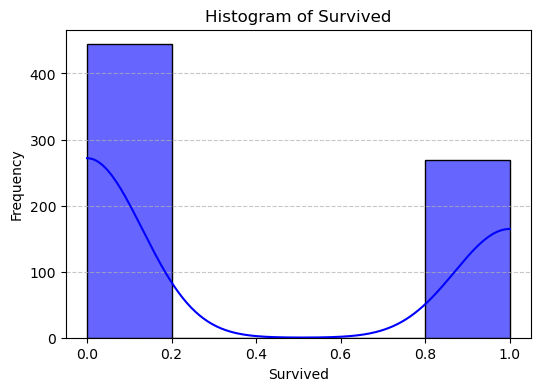

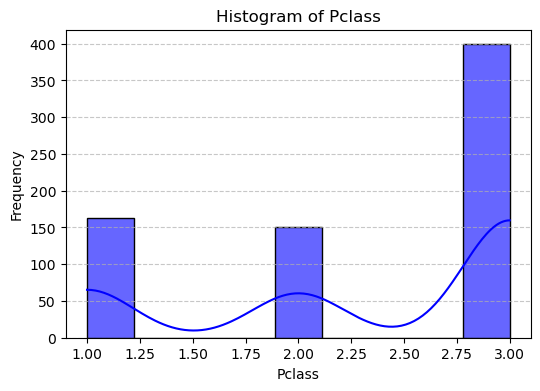

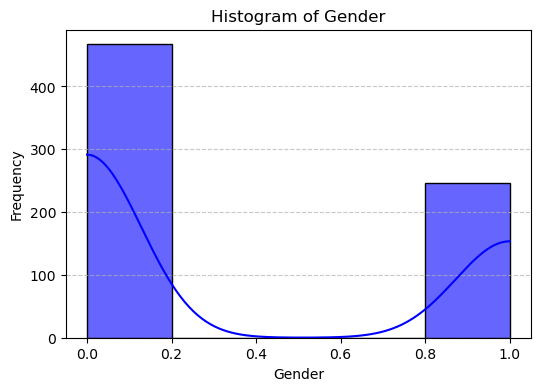

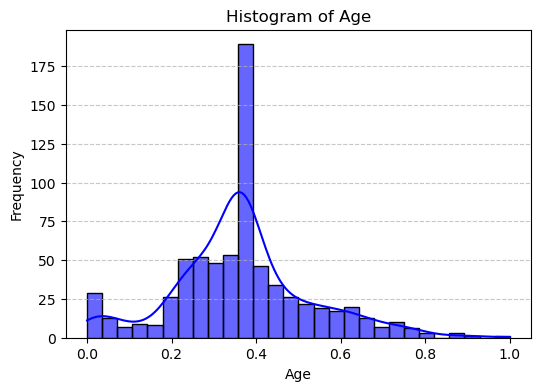

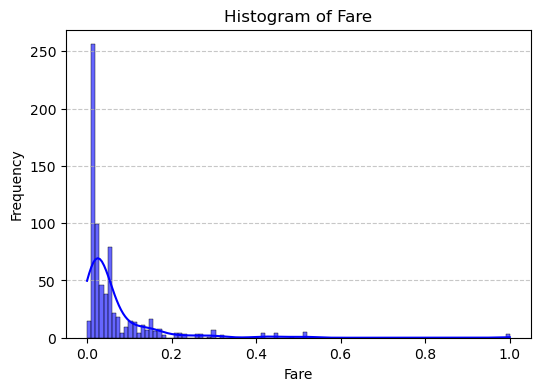

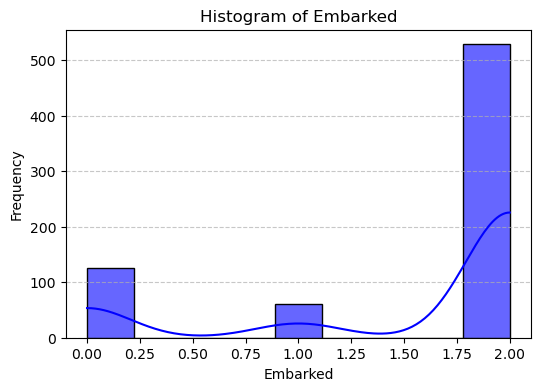

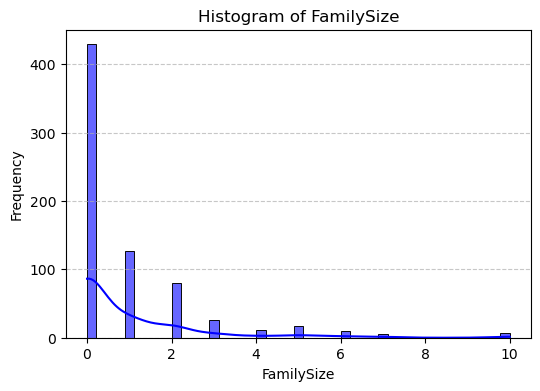

In [32]:
visualize_df_explore = scaled_filled_handled_cate_df.copy()
list_columns = visualize_df_explore.drop("PassengerId", axis=1).columns
for col in list_columns:
    step_1.plot_histogram(visualize_df_explore, col)

---

### Step 2: Evaluate a Decision Tree Classifier 
##### In this step, your goal is to use the Decision Tree classifier and tune its parameters so that your model will perform well on unseen data (the unseen data is not included in this lab). The parameters you are allowed to tune using GridSearchCV* from scikit-learn are:<br>

• max_depth: The maximum depth of the tree.<br>
• min_samples_split: The minimum number of samples required to split a node.<br>
• min_samples_leaf: The minimum number of samples required to be in a leaf node.<br>
• criterion: you have only two options: “gini” or “entropy”.<br>
For other parameters, use the default values given by scikit-learn.<br>
The result of Step 2 is a Decision Tree model with its parameters and performance measures based on the chosen parameters.<br>

##### You must implement a function named test_Decision_tree(file_name, model), which follows these requirements:<br>
• file_name: The name of the file containing the dataset (similar to the one provided).<br>
• model: The best Decision Tree model you have designed and trained.<br>

##### This function should:<br>
• Load the dataset from file_name.<br>
• Compute all relevant performance metrics based on the model (e.g., accuracy, recall, precision, etc.).<br>
• Print the results.<br>

I will use this function to evaluate your Decision Tree model on unseen data that I have.<br>

* GridSearchCV is a technique in scikit-learn for tuning the hyperparameters of a machine learning model by performing an exhaustive search over a specified parameter grid. <br>

In [33]:
#Dataset done scaled_filled_handled_cate_df

In [34]:
scaled_filled_handled_cate_df

,PassengerId,Survived,Pclass,Gender,Age,Fare,Embarked,FamilySize
PassengerId,,,,,,,,
121,121,0,3,0,0.271204,0.014151,2,1
330,330,1,1,1,0.472251,0.139136,0,1
40,40,1,3,1,0.321466,0.015469,2,0
295,295,1,1,1,0.434555,0.103644,2,1
654,654,0,3,0,0.434555,0.015713,2,0
...,...,...,...,...,...,...,...,...
72,72,0,2,0,0.346597,0.020495,2,0
107,107,0,3,0,0.308900,0.013761,2,0
271,271,1,1,1,0.233508,0.058556,2,0


In [35]:
class step_2_decision_tree_classifier():
    def __init__(self, data):
        self.data = data
        self.X = None
        self.Y = None
        self.best_model = None

    def train_model(self, param_grid):
        """
        Trains a Decision Tree model using GridSearchCV.

        :param param_grid: Dictionary of hyperparameters to optimize.
        :return: Best trained model
        """

        self.X = self.data.drop(['Survived','PassengerId'], axis=1)  # Features
        self.Y = self.data["Survived"]  # Target variable

        # Split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.Y, test_size=0.25, random_state=42, stratify=self.Y)

        # Initialize Decision Tree model
        dt = DecisionTreeClassifier(random_state=42)

        # Perform GridSearchCV
        grid_search = GridSearchCV(dt, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Store the best model
        self.best_model = grid_search.best_estimator_

        # Return the trained model
        return self.best_model
    

    def plot_model(self):
        """
        Plots the decision tree of the given model.

        :param model: Trained DecisionTreeClassifier model to visualize.
        """
        plt.figure(figsize=(15, 8))
        plot_tree(
            self.best_model, 
            feature_names=self.X.columns.tolist(),  
            class_names=["Not Survived", "Survived"], 
            filled=True, 
            rounded=True
        )
        plt.show()


    def test_decision_tree(self, file_name, model):
        """
        Tests the trained decision tree model on a new dataset.

        :param file_name: Path to the dataset file.
        :param model: Trained DecisionTreeClassifier model.
        :return: accuracy, precision, recall, f1 performance metrics
        """
        # Load the dataset
        Data = step_1_load_explore(file_name) 
        df_raw_ = Data.raw_df

        # Prepare the Data
        df_filled = Data.fill_missing_values("Age", df_raw_["Age"].mean())
        df_filled = Data.fill_missing_values("Embarked", df_raw_["Embarked"].mode()[0])
        scaled_filled_df = Data.scale_numerical_variables(df_filled, "Age", "Min-Max")
        scaled_filled_df = Data.scale_numerical_variables(scaled_filled_df, "Fare", "Min-Max")
        processed_data = Data.convert_categorical_variables(scaled_filled_df)

        # Define test features and target variable
        X_test = processed_data.drop(['Survived','PassengerId'], axis=1)
        y_test = processed_data["Survived"]

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Return the performance metrics
        return accuracy, precision, recall, f1

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)
Accuracy: 0.8499
Precision: 0.9500
Recall: 0.6357
F1 Score: 0.7617


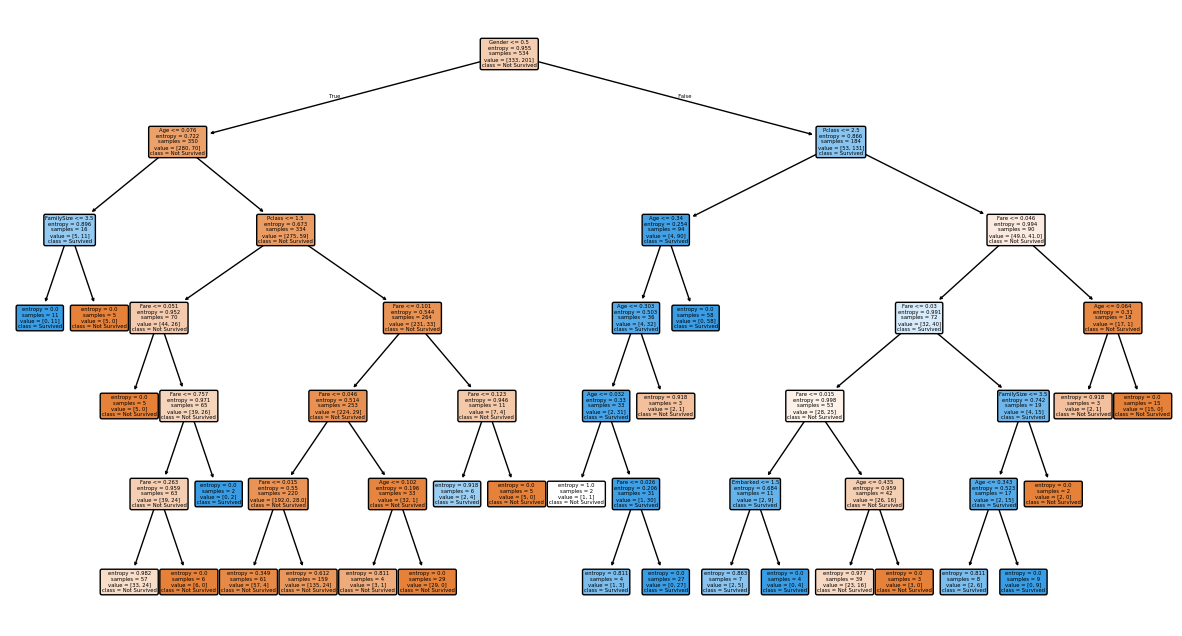

In [36]:
custom_param_grid = {
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "criterion": ["gini", "entropy"]
}

decision_tree_classifier = step_2_decision_tree_classifier(scaled_filled_handled_cate_df)
best_model = decision_tree_classifier.train_model(param_grid=custom_param_grid)
print(best_model)

accuracy, precision, recall, f1 = decision_tree_classifier.test_decision_tree("./Dataset/dataset.csv", best_model)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


decision_tree_classifier.plot_model()


---

### Step 3: Evaluate a KNN Classifier

In this step, your goal is to use the KNN classifier and tune its parameter (k) using GridSearchCV from scikit-learn, so that your model will perform well on unseen data (the unseen data is not included in this lab). For other parameters, use the default values given by scikit-learn. <br>
The result of Step 3 is a KNN model with its parameter k and performance measures based on the chosen k.<br>
You must implement a function named test_knn(file_name, model), which follows these requirements:<br>
• file_name: The name of the file containing the dataset (similar to the one provided).<br>
• model: The best KNN model you have designed and trained.<br>

This function should:<br>
• Load the dataset from file_name.<br>
• Compute all relevant performance metrics based on the model (e.g., accuracy, recall, precision, etc.).<br>
• Print the results.<br>
I will use this function to evaluate your KNN model on unseen data that I have.<br>

In [39]:
# Define Data Preprocessing Function
class step_3_knn_classifier():
    def __init__(self, data):
        self.data = data
        self.X = None
        self.Y = None

    def preprocess_data(self, file_name):
    
        #Preprocesses the dataset by handling missing values, scaling numerical features, 
        #and encoding categorical variables.

        # Load the dataset
        df = step_1_load_explore(file_name)
        df_raw_ = df.raw_df

        # Prepare the Data
        df_filled = df.fill_missing_values("Age", df_raw_["Age"].mean())
        df_filled = df.fill_missing_values("Embarked", df_raw_["Embarked"].mode()[0])
        scaled_filled_df = df.scale_numerical_variables(df_filled, "Age", "Min-Max")
        scaled_filled_df = df.scale_numerical_variables(scaled_filled_df, "Fare", "Min-Max")
        processed_data = df.convert_categorical_variables(scaled_filled_df)

        # Define test features and target variable
        X_test = processed_data.drop(['Survived','PassengerId'], axis=1)
        y_test = processed_data["Survived"]
    
        return X_test, y_test
    
    # Hyperparameter Tuning and Model Training
    def get_best_knn_model(self):
    
        #Uses GridSearchCV to find the best K value for the KNN classifier.
        #Returns the trained model with the best K value.
    
        self.X = self.data.drop(['Survived','PassengerId'], axis=1)
        self.Y = self.data["Survived"]
        
        # Split the dataset into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(self.X, self.Y, test_size=0.25, random_state=42, stratify=self.Y)
    
        # Define parameter grid
        param_grid = {'n_neighbors': range(1, 21)}
    
        # Initialize the KNN classifier
        knn = KNeighborsClassifier()
    
        # Perform GridSearchCV
        grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
    
        # Get the best K value
        best_k = grid_search.best_params_['n_neighbors']
        print(f'Best K value: {best_k}')
    
        # Train the final KNN model with the best K value
        best_knn = KNeighborsClassifier(n_neighbors=best_k)
        best_knn.fit(X_train, y_train)
    
        return best_knn

    # Testing the KNN Classifier
    def test_knn(self, file_name, model):
        #Tests the trained KNN model on unseen data and prints performance metrics.
        # Preprocess the dataset
        X_test, y_test = self.preprocess_data(file_name)
    
        # Make predictions
        y_pred = model.predict(X_test)
    
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
    
        # Confusion Matrix and Classification Report
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
    
        # Display Results
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print('\nConfusion Matrix:\n', conf_matrix)
        print('\nClassification Report:\n', class_report)
    
        # Plot Confusion Matrix
        ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
        plt.show()

Best K value: 11
Accuracy: 0.8135
Precision: 0.8151
Recall: 0.8135
F1 Score: 0.8075

Confusion Matrix:
 [[408  36]
 [ 97 172]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       444
           1       0.83      0.64      0.72       269

    accuracy                           0.81       713
   macro avg       0.82      0.78      0.79       713
weighted avg       0.82      0.81      0.81       713



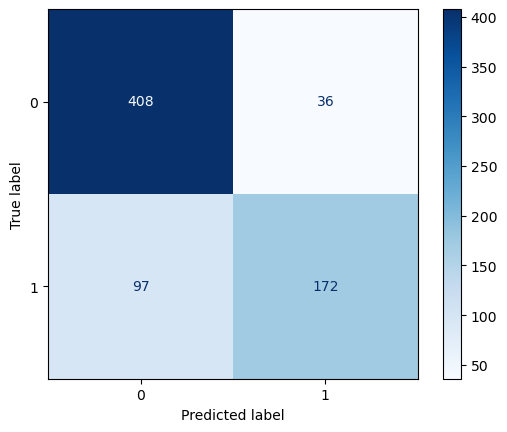

,PassengerId,Survived,Pclass,Gender,Age,Fare,Embarked,FamilySize
PassengerId,,,,,,,,
121,121,0,3,0,0.271204,0.014151,2,1
330,330,1,1,1,0.472251,0.139136,0,1
40,40,1,3,1,0.321466,0.015469,2,0
295,295,1,1,1,0.434555,0.103644,2,1
654,654,0,3,0,0.434555,0.015713,2,0
437,437,0,1,0,0.673298,0.101229,2,0
66,66,0,3,0,0.019895,0.041136,2,4
617,617,1,3,1,0.334031,0.021731,2,2
79,79,1,2,1,0.170680,0.058694,0,1


In [40]:
knn_classifier = step_3_knn_classifier(scaled_filled_handled_cate_df)
knn_model = knn_classifier.get_best_knn_model()
knn_classifier.test_knn("./Dataset/dataset.csv", knn_model)

scaled_filled_handled_cate_df.head(10)


---

### Step 4: Reflection Questions

1. Which model performed better, Decision Tree or KNN? Justify your answer.

***

| | Decision Tree | KNN (best K)|
|-|---------------|-------------|
| Accuracy | 84.99% | 81.35% |
| Precision | 95% | 81.51% |
| Recall | 63.57% | 81.35% |
| F1 Score | 76.17% | 80.75% |

Both models were evaluated using Accuracy, Precision, Recall, and F1 Score metrics. 
Based on the results, the decision tree got a higher accuracy (84.99%) indicating that the model correctly predicted a slightly larger part of targets, the KNN got 81.75%. It is important to keep in mind that accuracy on its own is not enough to make any conclusions becase it does not always represent important aspects of the evaluated models. The decision tree also has  an extremely high precision rate of 95% compared to 81.51% of KNN, meaning that the decision tree accuractly predicts the survivals. However, the decision tree fails to identify many actual survivors based on the 63.57% recall rate, which is closer to a coin flip. KNN demonstrates a more balanced trade-off - it identifies survivors and avoids false positives at similar rates. The F1 Score for the KNN model is notably higher, indicating that it is better at maintaining balance between precision and recall. For our dataset in particular, we assume that it is extremely important to accuratly predict the number of survivors, and, since the decision tree, while having a good precision rate, demonstrates an unreliable recall rate, **the KNN model performs better** than the Decision Tree model. Keep in mind that we drop the PassengerID column that is unique for each passanger for training and testing the data
***

2. How did feature scaling affect the Decision Tree and KNN performances?

***Both models were ran and evaluated using data with scaled numerical columns (min-max method). Use both models again without scaling numerical data***

In [42]:
# we use the df_filled dataframe before it was scaled numerically. However, we still must convert categorical variables
df_filled_converted = step_1.convert_categorical_variables(df_filled)
df_filled_converted.head(10)

,PassengerId,Survived,Pclass,Gender,Age,Fare,Embarked,FamilySize
PassengerId,,,,,,,,
121,121,0,3,0,22.0,7.2500,2,1
330,330,1,1,1,38.0,71.2833,0,1
40,40,1,3,1,26.0,7.9250,2,0
295,295,1,1,1,35.0,53.1000,2,1
654,654,0,3,0,35.0,8.0500,2,0
437,437,0,1,0,54.0,51.8625,2,0
66,66,0,3,0,2.0,21.0750,2,4
617,617,1,3,1,27.0,11.1333,2,2
79,79,1,2,1,14.0,30.0708,0,1


In [43]:
# Train and evaluate the decision tree - following the same approach as in step 2
decision_tree_classifier_unscaled = step_2_decision_tree_classifier(df_filled_converted)
best_model_unscaled = decision_tree_classifier_unscaled.train_model(param_grid=custom_param_grid)
print(best_model_unscaled)

# Define test features and target variable
X_test = df_filled_converted.drop(['Survived','PassengerId'], axis=1)
y_test = df_filled_converted["Survived"]

# Make predictions
y_pred = best_model_unscaled.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)
Accuracy: 0.8485
Precision: 0.9497
Recall: 0.6320
F1 Score: 0.7589


In [48]:
# Train the KNN model - following the same approach as in step 3
knn_classifier_unscaled = step_3_knn_classifier(df_filled_converted)
knn_model = knn_classifier_unscaled.get_best_knn_model()

X_test = df_filled_converted.drop(['Survived','PassengerId'], axis=1)
y_test = df_filled_converted["Survived"]

y_pred = knn_model.predict(X_test)

# Evaluate the KNN model 
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Best K value: 9
Accuracy: 0.7419
Precision: 0.7373
Recall: 0.7419
F1 Score: 0.7343


***
| | DT (scaling) | DT (no scaling) | KNN (best K, scaling)| KNN (best K, no scaling) |
|-|---------------|----------------|----------------------|--------------------------|
| Accuracy | 84.99% | 84.85% | 81.35% | 74.19% |
| Precision | 95% | 94.97% | 81.51% | 73.73% |
| Recall | 63.57% | 63.20% | 81.35% | 74.19% |
| F1 Score | 76.17% | 75.89% | 80.75% | 73.43% |

As we can see from the results, the decision tree model was not affected by data scaling since they work by splitting the data based on criterion (for example: Gini) and other hyperparameters and don't work with distances, unlike KNN. This means that no matter how we scale the data, the performance metrics for decision trees will remain **unchanged**. 

KNN, on the other hand, works by calculating distances to identify the nearest neighbors. Without scaling, features with significantly larger numerical ranges (in our case - Age and Fare columns) dominate the distance metric negatively affecting the performance metrics. We can see a significant decrease in accuracy, precision, recall, and F1 Score (~7%) that demonstrates how scaling affects the performance. In other words, the KNN greatly improves from feature scaling. When you scale the data, the model demonstrates an increase in all performance metrics compared to its performance on unscaled data
***

---

## III. Instructions

### Step 1: Load, Explore and Preprocess the Dataset
In this step, your task is to explore and preprocess the dataset using your machine learning and visualization skills. This includes, but is not limited to:<br>


<b>

• Handle missing values. Since the data is small, do not remove any data—you must impute any missing values.
• Scale the features if needed.
• Convert categorical variables.
• Use visualization to explore the dataset

</b>

---

### Step 2: Evaluate a Decision Tree Classifier

In this step, your goal is to use the Decision Tree classifier and tune its parameters so that your model will perform well on unseen data (the unseen data is not included in this lab). The parameters you are allowed to tune using GridSearchCV* from scikit-learn are:<br>

• max_depth: The maximum depth of the tree.<br>
• min_samples_split: The minimum number of samples required to split a node.<br>
• min_samples_leaf: The minimum number of samples required to be in a leaf node.<br>
• criterion: you have only two options: “gini” or “entropy”.<br>

For other parameters, use the default values given by scikit-learn.<br>

The result of Step 2 is a Decision Tree model with its parameters and performance measures based on the chosen parameters.<br>

You must implement a function named test_Decision_tree(file_name, model), which follows these requirements:<br>
• file_name: The name of the file containing the dataset (similar to the one provided).<br>
• model: The best Decision Tree model you have designed and trained.<br>

This function should:<br>
• Load the dataset from file_name.<br>
• Compute all relevant performance metrics based on the model (e.g., accuracy, recall, precision, etc.).<br>
• Print the results.<br>

I will use this function to evaluate your Decision Tree model on unseen data that I have.<br>

* GridSearchCV is a technique in scikit-learn for tuning the hyperparameters of a machine learning model by performing an exhaustive search over a specified parameter grid.<br>

</b>

---

### Step 3: Evaluate a KNN Classifier      

In this step, your goal is to use the KNN classifier and tune its parameter (k) using GridSearchCV from scikit-learn, so that your model will perform well on unseen data (the unseen data is not included in this lab). For other parameters, use the default values given by scikit-learn.<br>
The result of Step 3 is a KNN model with its parameter k and performance measures based on the chosen k.<br>

You must implement a function named test_knn(file_name, model), which follows these requirements:<br>
• file_name: The name of the file containing the dataset (similar to the one provided).<br>
• model: The best KNN model you have designed and trained.<br>

This function should:<br>
• Load the dataset from file_name.<br>
• Compute all relevant performance metrics based on the model (e.g., accuracy, recall, precision, etc.).<br>
• Print the results. <br>

I will use this function to evaluate your KNN model on unseen data that I have.<br>

---

### Step 4: Reflection Questions 

<b>

1. Which model performed better, Decision Tree or KNN? Justify your answer.
2. How did feature scaling affect the Decision Tree and KNN performances?

</b>